In [1]:
# Import stuff
import os
import scipy
from tqdm import tqdm, trange
from joblib import Parallel,delayed
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt

%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
figsize(11, 9)

os.chdir('/media/bigdata/firing_space_plot/ephys_data')
from ephys_data import ephys_data
import visualize

In [2]:
data_dir = '/media/bigdata/Abuzar_Data/AS18/AS18_4Tastes_200229_154608'
dat = \
    ephys_data(data_dir)
dat.firing_rate_params = dict(zip(\
    ('type', 'step_size','window_size','dt', 'baks_resolution', 'baks_dt'),
    ('conv',1,250,1,1e-3,1e-3)))

dat.get_unit_descriptors()
dat.get_spikes()
dat.get_firing_rates()

All tastes have equal dimensions,concatenating and normalizing


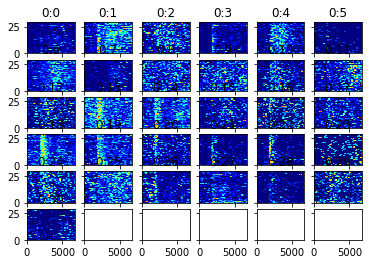

In [3]:
# Use MCMC changepoint separately on trials for single neuron
taste = 0
visualize.firing_overview(dat.firing_array[taste]);plt.show()

In [4]:
nrn = 6
this_dat = dat.spikes[taste][:,nrn]
print(this_dat.shape)

(30, 7000)


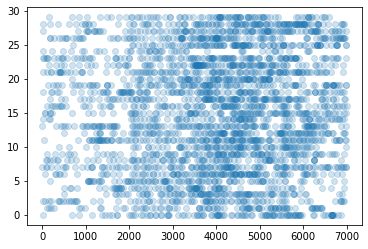

In [5]:
spike_inds = np.where(this_dat)
plt.scatter(spike_inds[1],spike_inds[0],alpha = 0.2)

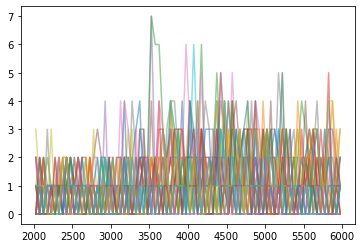

In [6]:
# Convert spikes to counts by binning
time_lims = [2000,6000]
bin_width = 50
t_vec = np.arange(this_dat.shape[-1])
binned_t_vec = np.mean(t_vec[time_lims[0]:time_lims[1]].reshape((-1,bin_width)),axis=-1)
this_dat_binned = np.sum(this_dat[...,time_lims[0]:time_lims[1]].reshape(this_dat.shape[0],-1,bin_width),axis=-1)
this_dat_binned = np.vectorize(np.int)(this_dat_binned)
plt.plot(binned_t_vec,this_dat_binned.T,alpha =0.5);plt.show()

[23 24 21 18 22 17 26 24 27 24 21 19 23 19 20 18 18 23 24 25 23 16 27 31
 22 25 25 28 29 24 39 36 42 42 25 44 40 38 35 37 50 41 41 40 31 32 34 45
 43 44 36 50 32 36 36 45 30 42 27 33 37 33 21 35 40 30 26 22 26 28 40 35
 39 31 17 24 34 24 21 28]
Average count = 30.2875


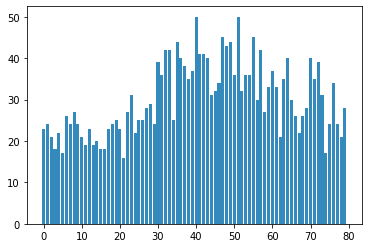

In [7]:
#trial = 0
#count_data = this_dat_binned[trial]
count_data = np.sum(this_dat_binned,axis=0)
n_count_data = len(count_data)
print(count_data)
print('Average count = {}'.format(count_data.mean()))
plt.bar(np.arange(n_count_data),count_data,color="#348ABD");plt.show()


In [225]:
states = 4
with pm.Model() as model:
    # Defining variables with priors
    alpha = 1.0/count_data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    #lambda_1 = pm.Exponential("lambda_1", alpha)
    #lambda_2 = pm.Exponential("lambda_2", alpha)
    #lambda_3 = pm.Exponential("lambda_3", alpha)
    #lambda_4 = pm.Exponential("lambda_4", alpha)
    
    lambda_latent = pm.Exponential("lambda_latent", alpha, shape = states) 
    


In [226]:
idx = np.arange(n_count_data) # Index
idx_range = idx.max() - idx.min()
print(idx.min())
print(idx.max())

0
79


In [227]:
even_changepoints = np.linspace(0,1,states+1)
even_changepoints[1:-1]
concentration_params = even_changepoints[1:-1] / np.min(even_changepoints[1:-1])
print(concentration_params)

[1. 2. 3.]


In [228]:
with model:
    
    #tau_1 = pm.DiscreteUniform("tau_1", lower=0, upper=n_count_data)
    #tau_2 = pm.DiscreteUniform("tau_2", lower=tau_1, upper=n_count_data)
    
    # Scaled beta mixture "somewhere in the middle" prior
    #a = pm.HalfNormal('a_hp', 3.)
    #b = pm.HalfNormal('b_hp', 3.)
    #tau_1_latent = pm.Beta('tau_1_latent', a, b)
    #tau_2_latent = pm.Beta('tau_2_latent', a, b)
    #tau_3_latent = pm.Beta('tau_3_latent', a, b)
    #tau_1 = pm.Deterministic('tau_1', idx.min() + ((idx.max() - idx.min()) * tau_1_latent)   )
    #tau_2 = pm.Deterministic('tau_2', tau_1 + ((idx.max() - idx.min()) * tau_2_latent)   )
    #tau_3 = pm.Deterministic('tau_3', tau_2 + ((idx.max() - idx.min()) * tau_3_latent)   )
    
    tau_latent = pm.Dirichlet('tau_latent',concentration_params)#np.ones(states-1))#, testval = even_changepoints[1:-1])
    tau_ = pm.Deterministic('tau_', idx_range * tau_latent)
    #tau_1 = pm.Deterministic('tau_1', idx_range * tau_latent[0]   )
    #tau_2 = pm.Deterministic('tau_2', idx_range * tau_latent[1]   )
    #tau_3 = pm.Deterministic('tau_3', idx_range * tau_latent[2]   )
    

#print(tau_latent.tag.test_value)
#print(tau_1.tag.test_value)
#print(tau_2.tag.test_value)
#print(tau_3.tag.test_value)
print(tau_.tag.test_value)

[13.16666667 26.33333333 39.5       ]


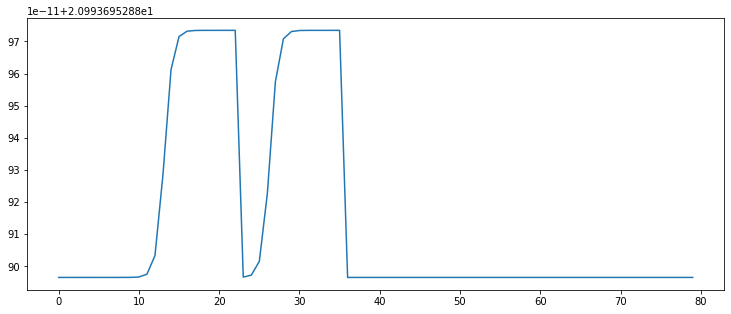

In [229]:
with model:
    
    #lambda_ = pm.math.switch(tau_2 >= idx, pm.math.switch(tau_1 >= idx, lambda_1, lambda_2), lambda_3)
    
    # Using sigmoid rather than switch is supposed to be better
    # for sampler
    #weight_1 = tt.nnet.sigmoid(2 * (idx - tau_1))
    #weight_2 = tt.nnet.sigmoid(2 * (idx - tau_2))
    #weight_3 = tt.nnet.sigmoid(2 * (idx - tau_3))
    
    weight_1 = tt.nnet.sigmoid(2 * (idx - tau_[0]))
    weight_2 = tt.nnet.sigmoid(2 * (idx - tau_[1]))
    weight_3 = tt.nnet.sigmoid(2 * (idx - tau_[2]))
    lambda_ = (1 - weight_1) * lambda_latent[0] + \
                weight_1 * (1 - weight_2) * lambda_latent[1] + \
                weight_2 * (1 - weight_3) * lambda_latent[2] + \
                weight_3 * lambda_latent[3]
    
    #lambda_ = (1 - weight_1) * lambda_latent[0] + \
    #        weight_1 * (1 - weight_2) * lambda_latent[1] + \
    #        weight_2 * lambda_latent[2]
    
plt.plot(lambda_.tag.test_value);

In [230]:
with model:
    observation = pm.Poisson("obs", lambda_, observed=count_data)

In [231]:
with model:
    #step = pm.Metropolis()
    #trace = pm.sample(15000, tune=5000,step=step)
    trace = pm.sample(15000, tune=5000, chains = 4, cores = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, lambda_latent]
Sampling 4 chains, 266 divergences: 100%|██████████| 80000/80000 [00:35<00:00, 2264.33draws/s]
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [232]:
pm.summary(trace).round(2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
lambda_latent[0],23.34,6.52,10.75,35.80,0.04,0.02,34784.0,34784.0,33618.0,19695.0,1.0
lambda_latent[1],22.36,0.98,20.57,24.23,0.00,0.00,39147.0,38950.0,39223.0,34256.0,1.0
lambda_latent[2],38.42,1.42,35.73,41.09,0.01,0.01,25960.0,25026.0,27442.0,15507.0,1.0
lambda_latent[3],31.46,1.16,29.36,33.70,0.01,0.00,26887.0,25994.0,27299.0,20173.0,1.0
tau_latent[0],0.01,0.01,0.00,0.03,0.00,0.00,1635.0,1197.0,9390.0,2818.0,1.0
tau_latent[1],0.35,0.02,0.32,0.38,0.00,0.00,19334.0,19334.0,19797.0,18972.0,1.0
tau_latent[2],0.64,0.02,0.61,0.68,0.00,0.00,2512.0,2512.0,8436.0,2744.0,1.0
tau_[0],0.74,1.03,0.00,2.06,0.02,0.02,1635.0,1197.0,9390.0,2818.0,1.0
tau_[1],27.57,1.28,25.47,29.84,0.01,0.01,19334.0,19334.0,19797.0,18972.0,1.0
tau_[2],50.70,1.67,47.90,53.31,0.03,0.02,2512.0,2512.0,8436.0,2744.0,1.0


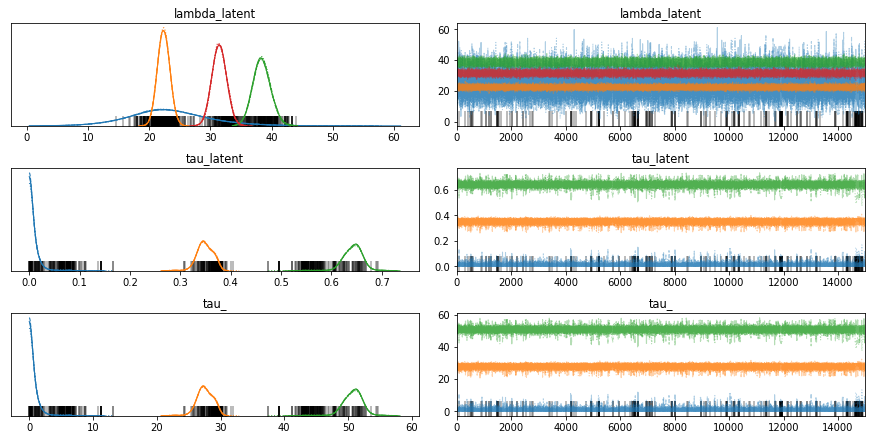

In [233]:
pm.traceplot(trace);

In [234]:
lambda_samples = trace['lambda_latent']
tau_samples = trace['tau_']
#lambda_1_samples = trace['lambda_1']
#lambda_2_samples = trace['lambda_2']
#lambda_3_samples = trace['lambda_3']
#lambda_4_samples = trace['lambda_4']
#tau_1_samples = trace['tau_1']
#tau_2_samples = trace['tau_2']
#tau_3_samples = trace['tau_3']

#lambda_stack = np.stack([lambda_1_samples, lambda_2_samples, lambda_3_samples, lambda_4_samples])
#tau_stack = np.stack([tau_1_samples, tau_2_samples, tau_3_samples])

#print(lambda_stack.shape)
print(lambda_samples.shape)
print(tau_samples.shape)

(60000, 4)
(60000, 3)


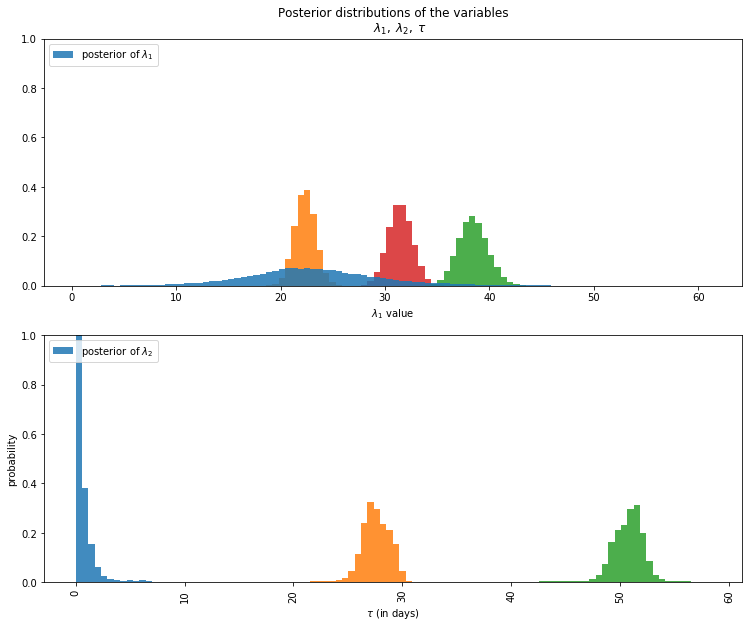

In [235]:
figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(211)
ax.set_autoscaley_on(False)

plt.hist(lambda_samples, histtype='stepfilled', bins=100, alpha=0.85,
         label="posterior of $\lambda_1$", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(212)
ax.set_autoscaley_on(False)
plt.hist(tau_samples, histtype='stepfilled', bins=100, alpha=0.85,
         label="posterior of $\lambda_2$", density=True)
plt.legend(loc="upper left")
plt.xlabel("$\lambda_2$ value")

plt.legend(loc="upper left")
plt.xlabel(r"$\tau$ (in days)")
plt.xticks(rotation='vertical')
plt.ylabel("probability");

In [236]:
ppc = pm.sample_posterior_predictive(trace, samples = 10000, model = model)

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 10000/10000 [00:15<00:00, 641.41it/s]


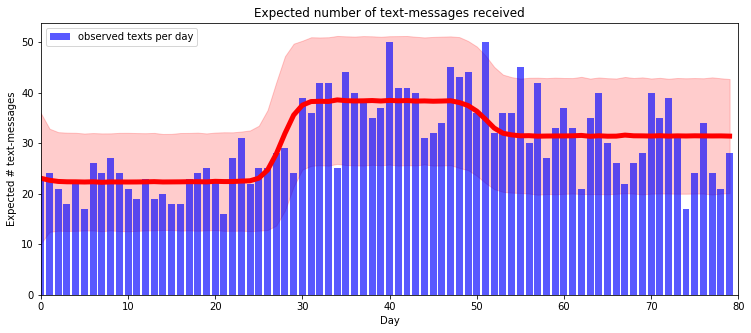

In [237]:
figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
#N = tau_1_samples.shape[0]
#expected_texts_per_day = np.zeros(n_count_data)
#for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    #ix1 = day < tau_1_samples
    #ix2 = (day >= tau_1_samples)*(day < tau_2_samples)
    #ix3 = day >= tau_2_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    #expected_texts_per_day[day] = (lambda_1_samples[ix1].sum()
    #                               + lambda_2_samples[ix2].sum()
    #                              + lambda_3_samples[ix3].sum()) / N

# Plot Mean trace with SD
mean_val = np.mean(ppc['obs'],axis=0)
std_val = np.std(ppc['obs'],axis=0)
plt.fill_between(x = np.arange(len(mean_val)),
                    y1 = mean_val - 2*std_val,
                    y2 = mean_val + 2*std_val,
                alpha = 0.2, color = 'red');
plt.plot(np.arange(len(mean_val)), mean_val, color = 'red', linewidth=5)

#plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
#         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.bar(np.arange(len(count_data)), count_data, color="blue", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");